### Specify the churned users based on the definition provided by the company.
lets load the datasets:

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import classification_report,roc_curve
from sklearn.datasets import make_classification

In [3]:
# Import data from .CSV file
path_equity_value_data = 'Data for robinhood/equity_value_data.csv'
equity_value_data = pd.read_csv(path_equity_value_data)

path_features_data = 'Data for robinhood/features_data.csv'
features_data = pd.read_csv(path_features_data)

In [4]:
# Print out the column types in the equity value dataset
print("Column types in the equity value dataset: \n {}".format(equity_value_data.dtypes))

Column types in the equity value dataset: 
 timestamp        object
close_equity    float64
user_id          object
dtype: object


In [5]:
# Determine the total number of users in the dataset
print("Number of users in the dataset: {}".format(len(equity_value_data.user_id.unique())))

Number of users in the dataset: 5584


In [6]:
# Change the format of "timestamp" column from string to date
Timestamp_timeformat= pd.to_datetime(equity_value_data['timestamp'],format='%Y-%m-%dT%H:%M:%S%z')
equity_value_data_processed = pd.concat([Timestamp_timeformat,equity_value_data[['close_equity', 'user_id']]],axis=1)

# Print out the column types in the equity value dataset after reformatting
print("Column types in the equity value dataset after reformatting the timestamp column : \n {}".format(equity_value_data_processed.dtypes))

Column types in the equity value dataset after reformatting the timestamp column : 
 timestamp       datetime64[ns, UTC]
close_equity                float64
user_id                      object
dtype: object


In [7]:
# Print out few rows of reformatted equity value dataset
print("Print few columns of equity value dataset after reformatting the timestamp column :\n")
equity_value_data_processed.head()

Print few columns of equity value dataset after reformatting the timestamp column :



,timestamp,close_equity,user_id
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [8]:
# Identify the churned users
churned_user = []
churned_user_id =[]
for ID in equity_value_data_processed.user_id.unique():
    churned_user_id.append(ID)
    Sub_equity_value_data = equity_value_data_processed[equity_value_data_processed.user_id == ID].timestamp.to_numpy()

    for i in range(len(Sub_equity_value_data)):
        
        if i == len(Sub_equity_value_data)-1:
            churned_user.append(0)
            break
        
        elif (Sub_equity_value_data[i+1]-Sub_equity_value_data[i]).days >=28:
            churned_user.append(1)
            break
        
        else:
            pass

In [9]:
# Determine the percentage of churned users
Percentage_of_churned = sum(churned_user)/len(churned_user)
print("what percentage of users have churned in the data provided ? {}".format(Percentage_of_churned*100))

what percentage of users have churned in the data provided ? 4.9964183381088825


In [10]:
# Create dataframe from the generated lists for churned users and churned users'id.  
churned_user_id_Pdseries = pd.DataFrame(churned_user_id)
churned_user_Pdseries = pd.DataFrame(churned_user)
churned_user_DataFrame = pd.concat([churned_user_id_Pdseries,churned_user_Pdseries], axis=1)
churned_user_DataFrame.columns= ['user_id','churned_status']

In [11]:
# Join the churned dataframe and features_data using user_id column as the key.
Prcessed_Dataframe = features_data.set_index('user_id').join(churned_user_DataFrame.set_index('user_id'))

In [12]:
# Print out few columns of Proccessed_Dataframe
print("Print out few columns of Proccessed_Dataframe after reformatting the timestamp column :\n")
Prcessed_Dataframe.head()

Print out few columns of Proccessed_Dataframe after reformatting the timestamp column :



,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churned_status
user_id,,,,,,,,,
895044c23edc821881e87da749c01034,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,0
458b1d95441ced242949deefe8e4b638,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,0
c7936f653d293479e034865db9bb932f,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,0
b255d4bd6c9ba194d3a350b3e76c6393,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,0
4a168225e89375b8de605cbc0977ae91,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,0


### Define function to implement SMOTE method:



In [13]:
# Import the SMOTE from Imblearn library
from imblearn.over_sampling import SMOTE 
def smote_imbal(X,Y):
  ''' 
  The function implements the SMOTE oversampling on the imbalanced dataset.
  
  Input:
  X: feature set
  Y: labels

  Output:
  X_sm: feature set after SMOTE oversampling
  y_sm: labels after SMOTE oversampling
  '''
  smote = SMOTE (sampling_strategy = 'minority')
  X_sm, y_sm = smote.fit_resample(X,Y)
  return X_sm, y_sm
  

### Build the classificaiton model:
Prepare the dataset:

In [14]:
# Create feature set and labels set
X = Prcessed_Dataframe[['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon']]
Y = Prcessed_Dataframe[['churned_status']]

In [15]:
# Determine the columns with categorical variables in X set:
print("Column types in X set: \n {}".format(X.dtypes))

Column types in X set: 
 risk_tolerance                   object
investment_experience            object
liquidity_needs                  object
platform                         object
time_spent                      float64
instrument_type_first_traded     object
first_deposit_amount            float64
time_horizon                     object
dtype: object


In [16]:
# Determine the unique values in each column of X set:
print("Unique values in each column of X set: \n {}".format(X.nunique()))


Unique values in each column of X set: 
 risk_tolerance                     3
investment_experience              4
liquidity_needs                    3
platform                           3
time_spent                      4502
instrument_type_first_traded      11
first_deposit_amount             317
time_horizon                       3
dtype: int64


In [17]:

# Determine the columns with missing values:
print("Is there any missing value in each column: \n {}".format(X.isnull().any()))

Is there any missing value in each column: 
 risk_tolerance                  False
investment_experience           False
liquidity_needs                 False
platform                        False
time_spent                      False
instrument_type_first_traded    False
first_deposit_amount            False
time_horizon                    False
dtype: bool


In [18]:
# Perform One-Hot encoding on columns with categorical variables
X_Onehot_cat = pd.get_dummies(X[['risk_tolerance','investment_experience','liquidity_needs','platform','instrument_type_first_traded','time_horizon']])
X_encoded = pd.concat([X_Onehot_cat,X[['time_spent', 'first_deposit_amount']]],axis=1)
# Print out few columns of encoded X set
print("Print out few columns of encoded X set: \n")
X_encoded.head()

Print out few columns of encoded X set: 



,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,investment_experience_no_investment_exp,liquidity_needs_not_important_liq_need,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,platform_Android,platform_both,platform_iOS,instrument_type_first_traded_0,instrument_type_first_traded_adr,instrument_type_first_traded_cef,instrument_type_first_traded_etp,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon,time_spent,first_deposit_amount
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
895044c23edc821881e87da749c01034,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,33.129417,40.0
458b1d95441ced242949deefe8e4b638,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,16.573517,200.0
c7936f653d293479e034865db9bb932f,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,10.008367,25.0
b255d4bd6c9ba194d3a350b3e76c6393,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.031633,100.0
4a168225e89375b8de605cbc0977ae91,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,8.187250,20.0


In [19]:
# Perform SMOTE oversampeling
X_encoded, Y = smote_imbal(X_encoded, Y)


Train and test XGBoost classification model:



In [20]:
# Import XGBoost library
from xgboost import XGBClassifier,plot_importance

# Fit the XGboost classifier 
model = XGBClassifier(max_depth=12, learning_rate=0.01)

# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Cross validate the model
Y = np.array(Y).ravel()
scores = cross_val_score(model, X_encoded, Y, scoring='roc_auc', cv=cv, n_jobs=-1)

# Print out the mean AUC
print('Mean AUC: %.3f' % np.mean(scores))

Mean AUC: 0.981


Determine the top three features based on XGboost model:

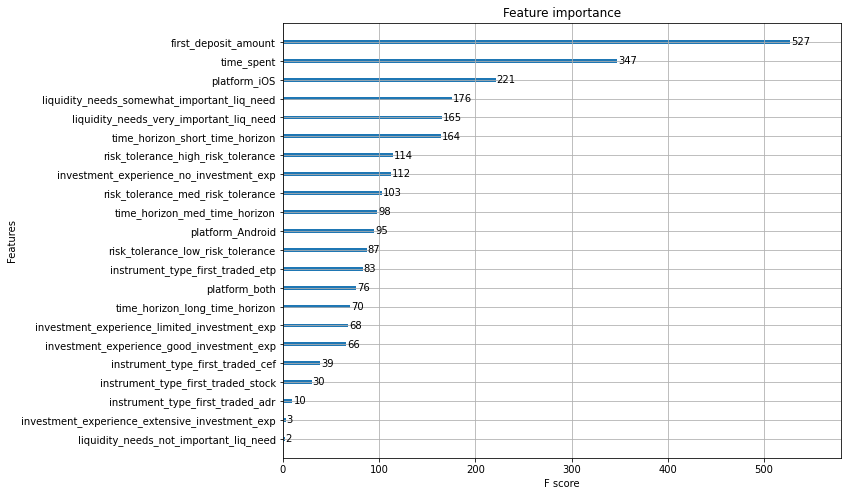

In [21]:
# Rank the features based on their importance
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=40)
model= XGBClassifier(max_depth=5, learning_rate=0.01,scale_pos_weight=13)
xgb_model = model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax);